In [7]:

# Lấy dữ liệu từ file processed.cleveland.data
import pandas as pd

column_names = [
    "age",         # tuổi
    "sex",         # giới tính (1 = nam, 0 = nữ)
    "cp",          # loại đau ngực
    "trestbps",    # huyết áp khi nghỉ
    "chol",        # cholesterol
    "fbs",         # đường huyết lúc đói > 120 mg/dl (1/0)
    "restecg",     # kết quả ECG lúc nghỉ
    "thalach",     # nhịp tim tối đa đạt được
    "exang",       # đau thắt ngực do gắng sức (1/0)
    "oldpeak",     # ST chênh so với nghỉ
    "slope",       # độ dốc đoạn ST
    "ca",          # số lượng mạch chính được nhuộm màu (0–3)
    "thal",        # kết quả thallium test (3 = bình thường, 6 = lỗi cố định, 7 = lỗi có thể phục hồi)
    "target"       # nhãn kết quả (0 = không bệnh, 1-4 = có bệnh)
]

# URL to the processed Cleveland dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

df = pd.read_csv(url, names=column_names, na_values='?')
# target > 0 thành 1 vì chỉ phân biệt có bệnh hay không
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# điền dữ liệu bị thiếu 
df["ca"] = df["ca"].fillna(df["ca"].median())
df["thal"] = df["thal"].fillna(df["thal"].mode()[0]) 
# sau khi điền dữ liệu bị thiếu

In [8]:
# drop bỏ cái cột target
X = df.drop("target", axis=1)
# bảng mỗi cột target
y = df["target"]

from sklearn.model_selection import train_test_split

split_ratios = [0.4, 0.6, 0.8, 0.9]
datasets = {}

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=1-ratio,
        shuffle=True,
        stratify=y,
        random_state=42
    )
    # lưu dữ liệu vào data set
    # ví dụ  0.4_0.6 là tỉ lệ 40% train và 60% test
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}" 
    # cộng với 0.001 để tránh làm tròn xuống =))
    datasets[f"feature_train_{key}"] = X_train
    datasets[f"label_train_{key}"] = y_train
    datasets[f"feature_test_{key}"] = X_test
    datasets[f"label_test_{key}"] = y_test

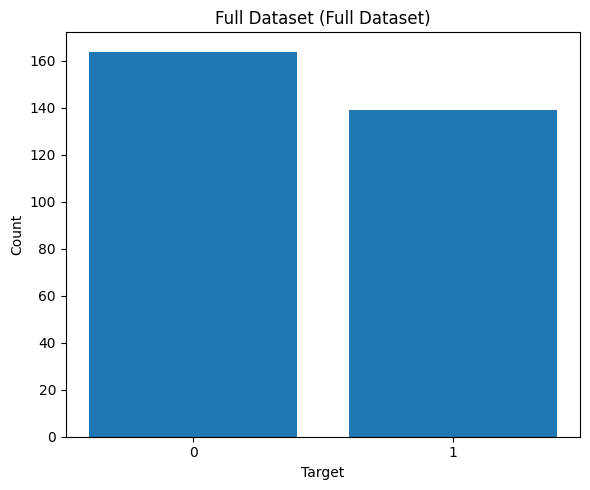

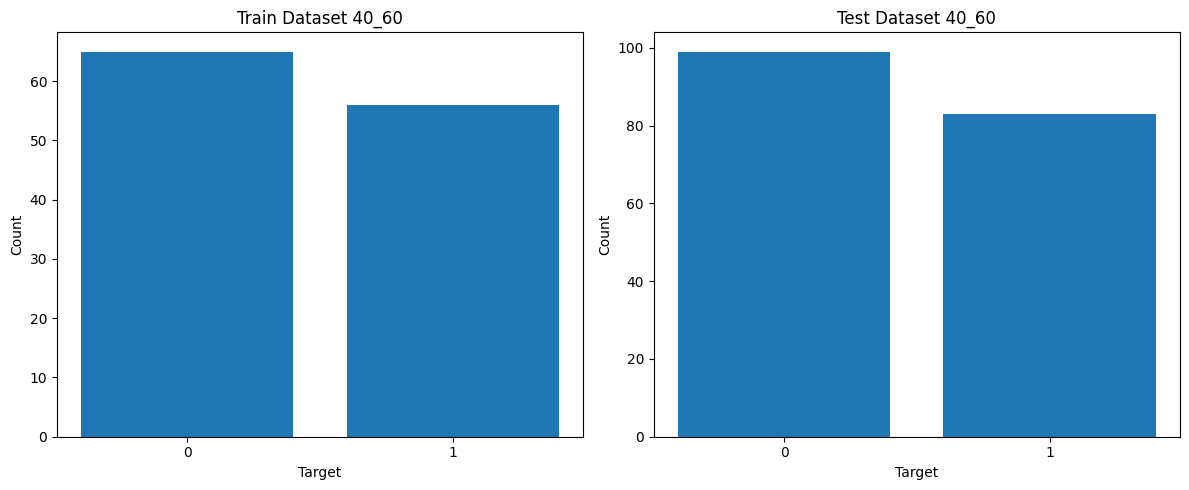

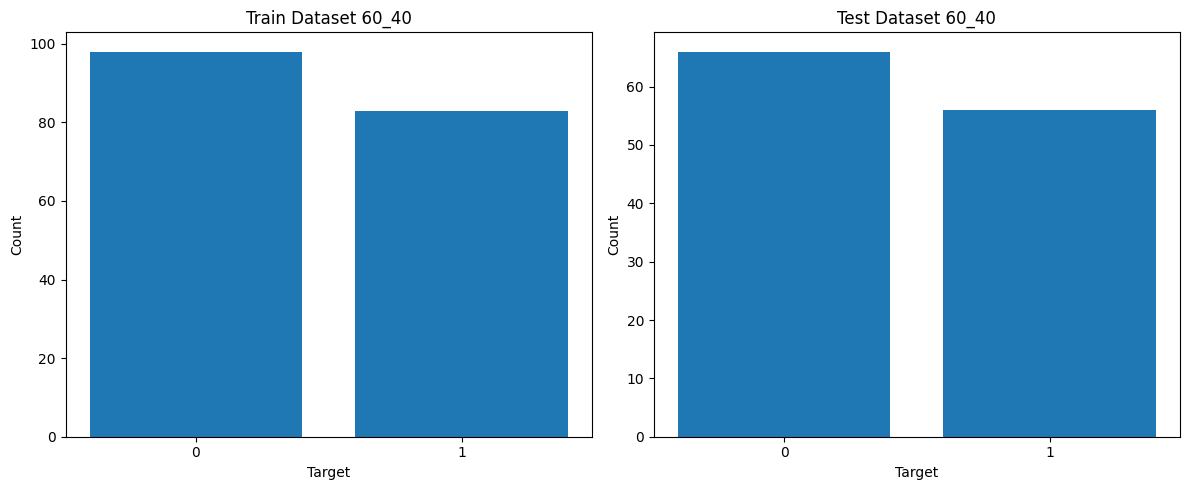

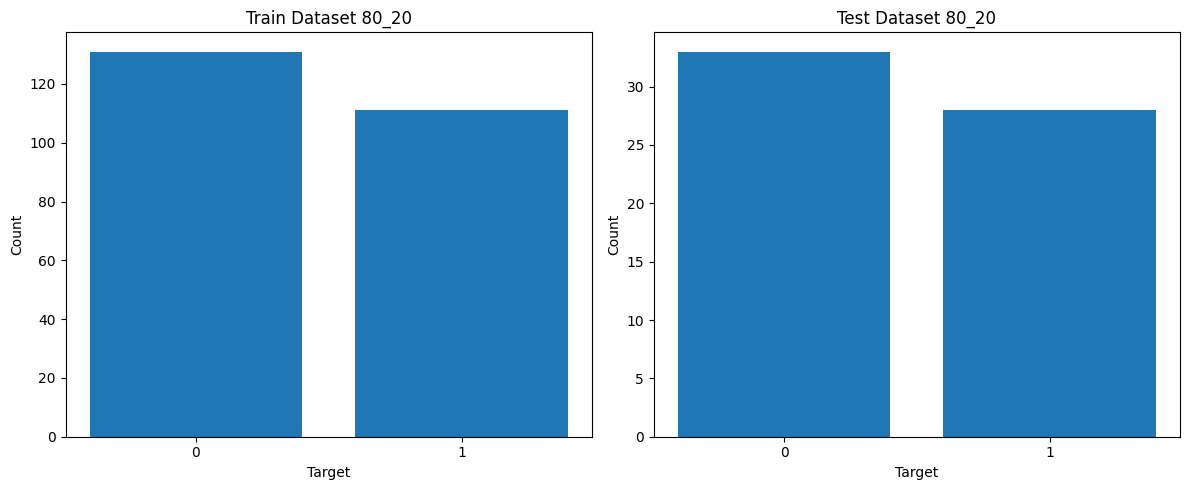

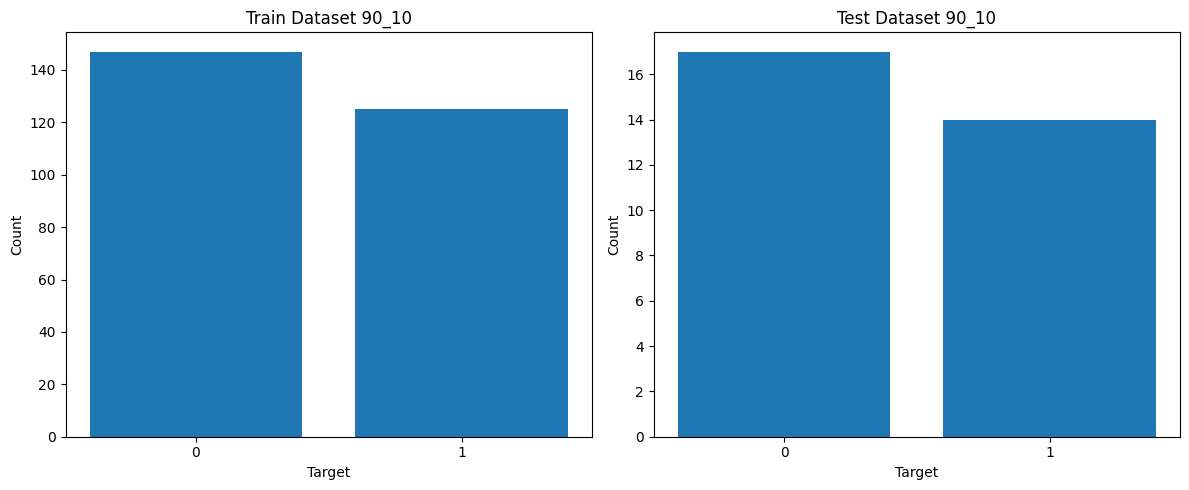

In [9]:
import matplotlib.pyplot as plt

def plot_distribution(y_train, y_test, title_train, title_test):
    if y_train.equals(y_test):
        # If y_train and y_test are identical, plot only one graph
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))

        counts = y_train.value_counts().sort_index()
        labels = counts.index
        values = counts.values

        ax.bar(labels, values)
        ax.set_title(f"{title_train} (Full Dataset)")
        ax.set_xlabel("Target")
        ax.set_ylabel("Count")
        ax.set_xticks(labels)

    else:
        # Else, plot two side-by-side graphs
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot for the training set
        counts_train = y_train.value_counts().sort_index()
        labels_train = counts_train.index
        values_train = counts_train.values
        axes[0].bar(labels_train, values_train)
        axes[0].set_title(title_train)
        axes[0].set_xlabel("Target")
        axes[0].set_ylabel("Count")
        axes[0].set_xticks(labels_train)

        # Plot for the test set
        counts_test = y_test.value_counts().sort_index()
        labels_test = counts_test.index
        values_test = counts_test.values
        axes[1].bar(labels_test, values_test)
        axes[1].set_title(title_test)
        axes[1].set_xlabel("Target")
        axes[1].set_ylabel("Count")
        axes[1].set_xticks(labels_test)

    plt.tight_layout()
    plt.show()

# Visualize the full dataset (y vs y)
plot_distribution(y, y, "Full Dataset", "Full Dataset")

# Visualize each train/test split
for ratio in split_ratios:
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    plot_distribution(
        datasets[f"label_train_{key}"],
        datasets[f"label_test_{key}"],
        f"Train Dataset {key}",
        f"Test Dataset {key}"
    )


In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import display

# Store the decision trees for each split
decision_trees = {}

# Loop through each train/test split
for ratio in split_ratios:
    # Create the key (example: 40_60, 60_40, etc.)
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Get feature_train and label_train
    X_train = datasets[f"feature_train_{key}"]
    y_train = datasets[f"label_train_{key}"]

    # Create and train the Decision Tree
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    decision_trees[f"decision_tree_{key}"] = clf


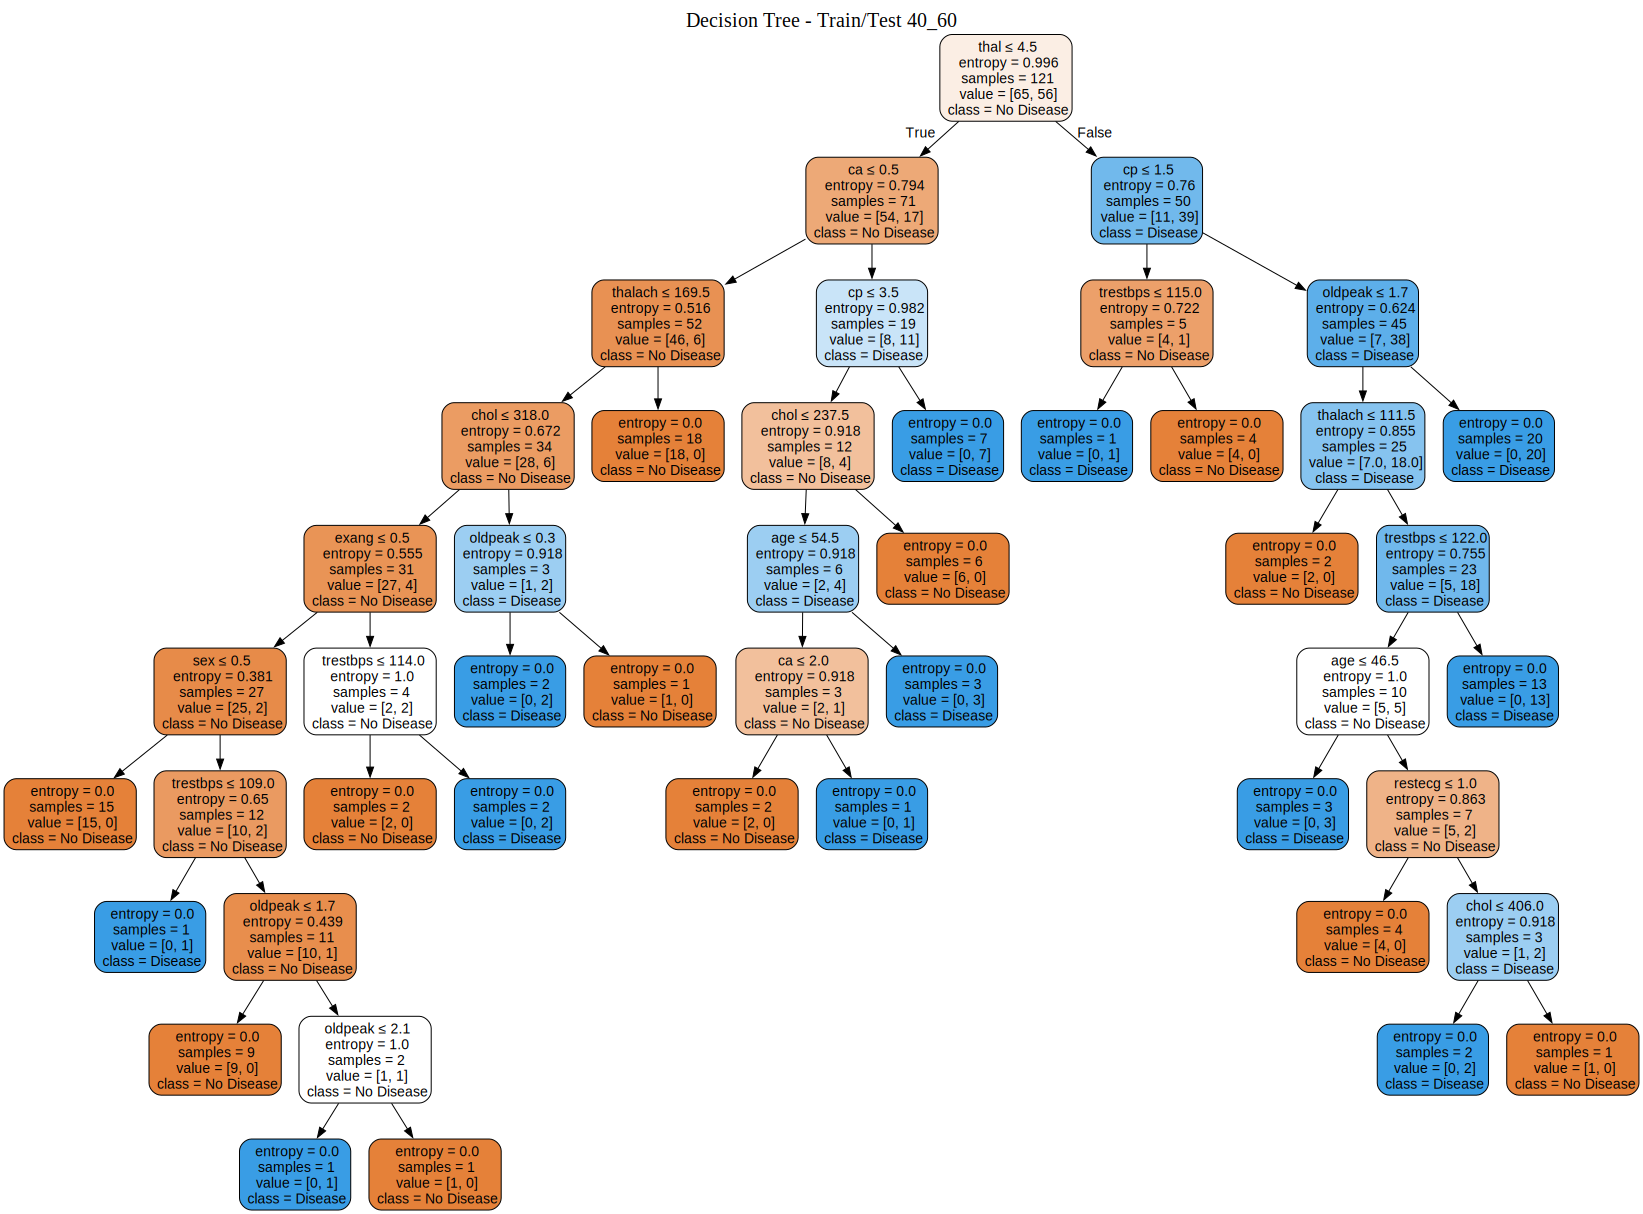

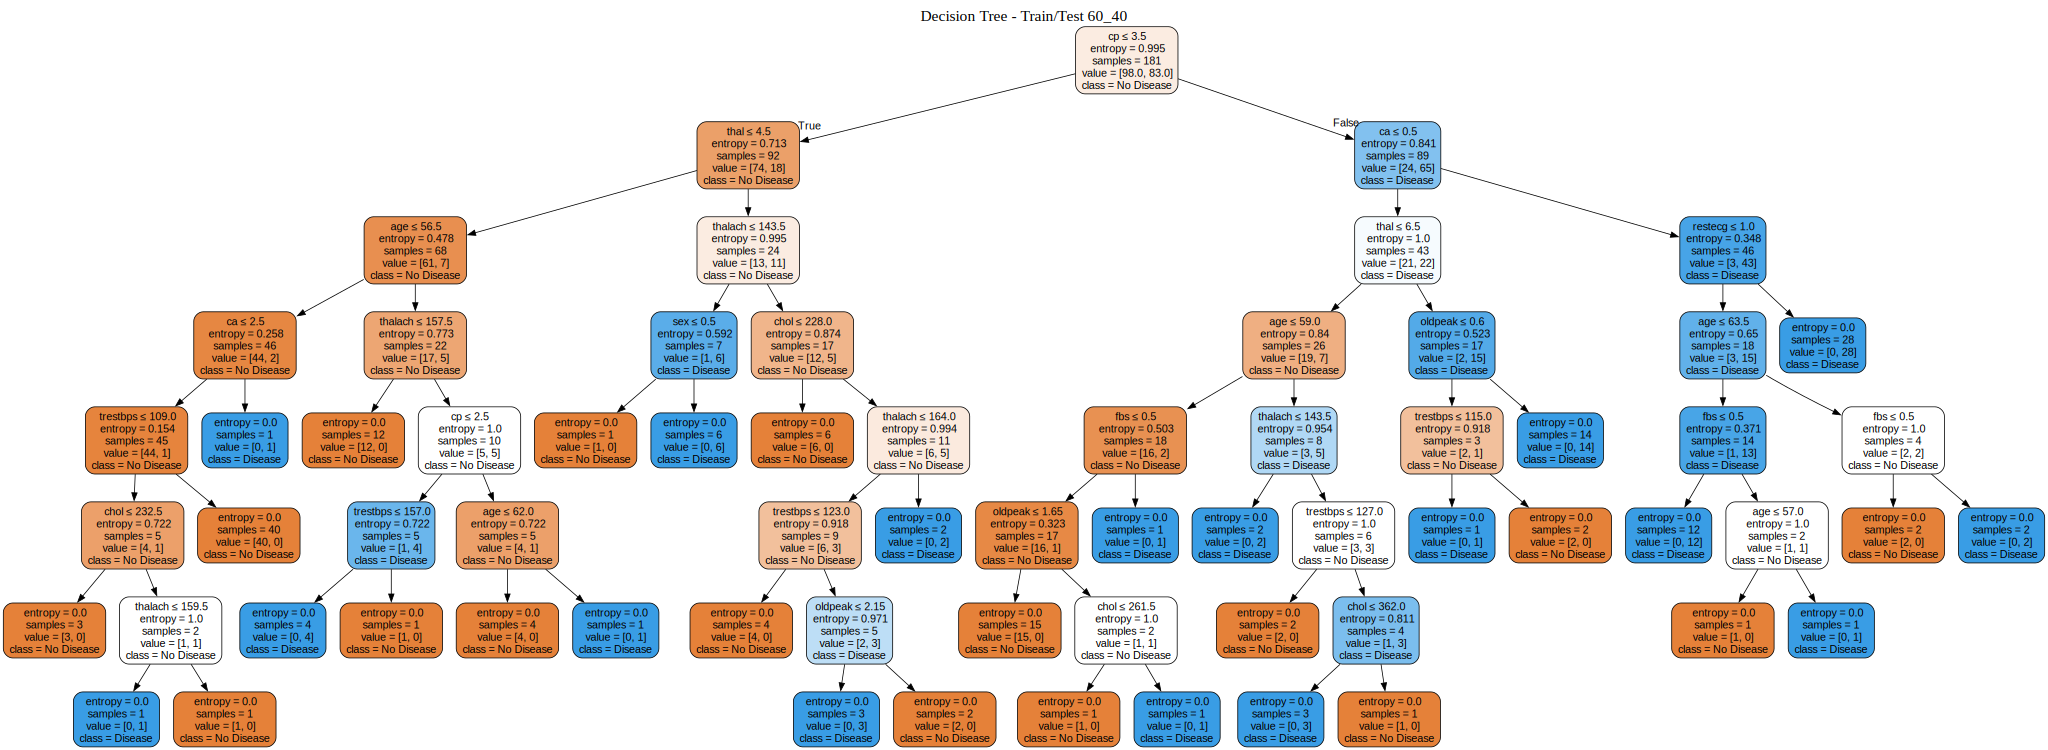

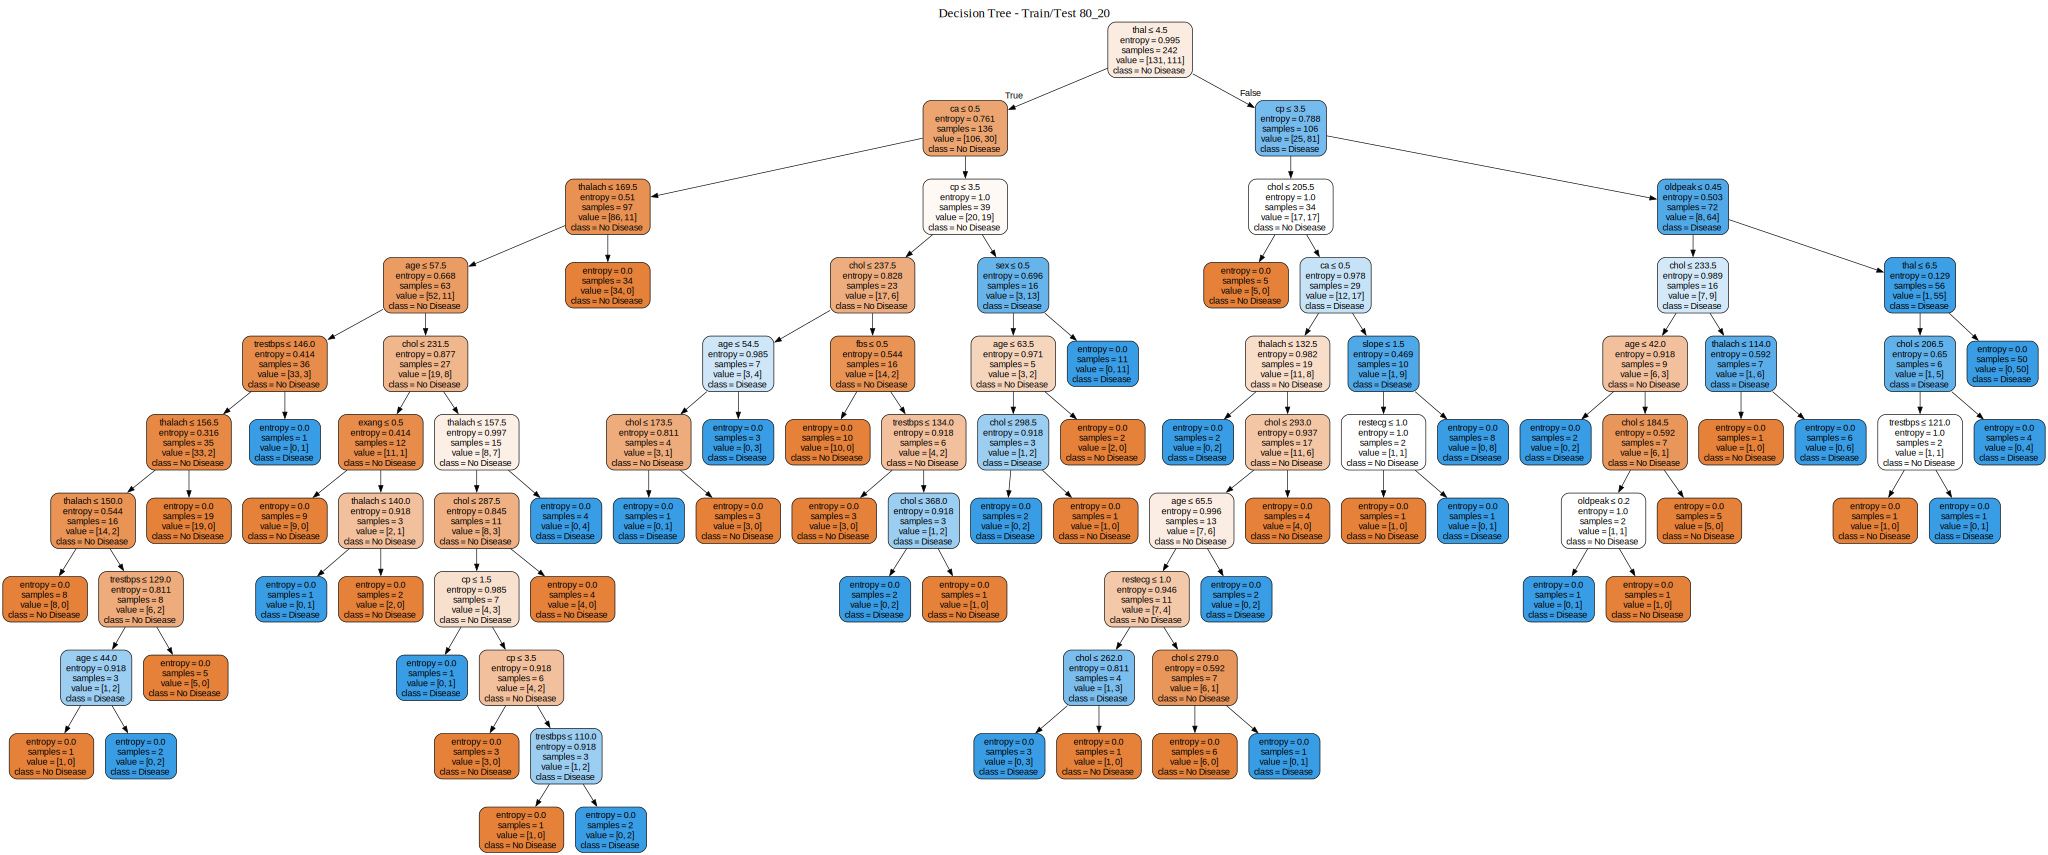

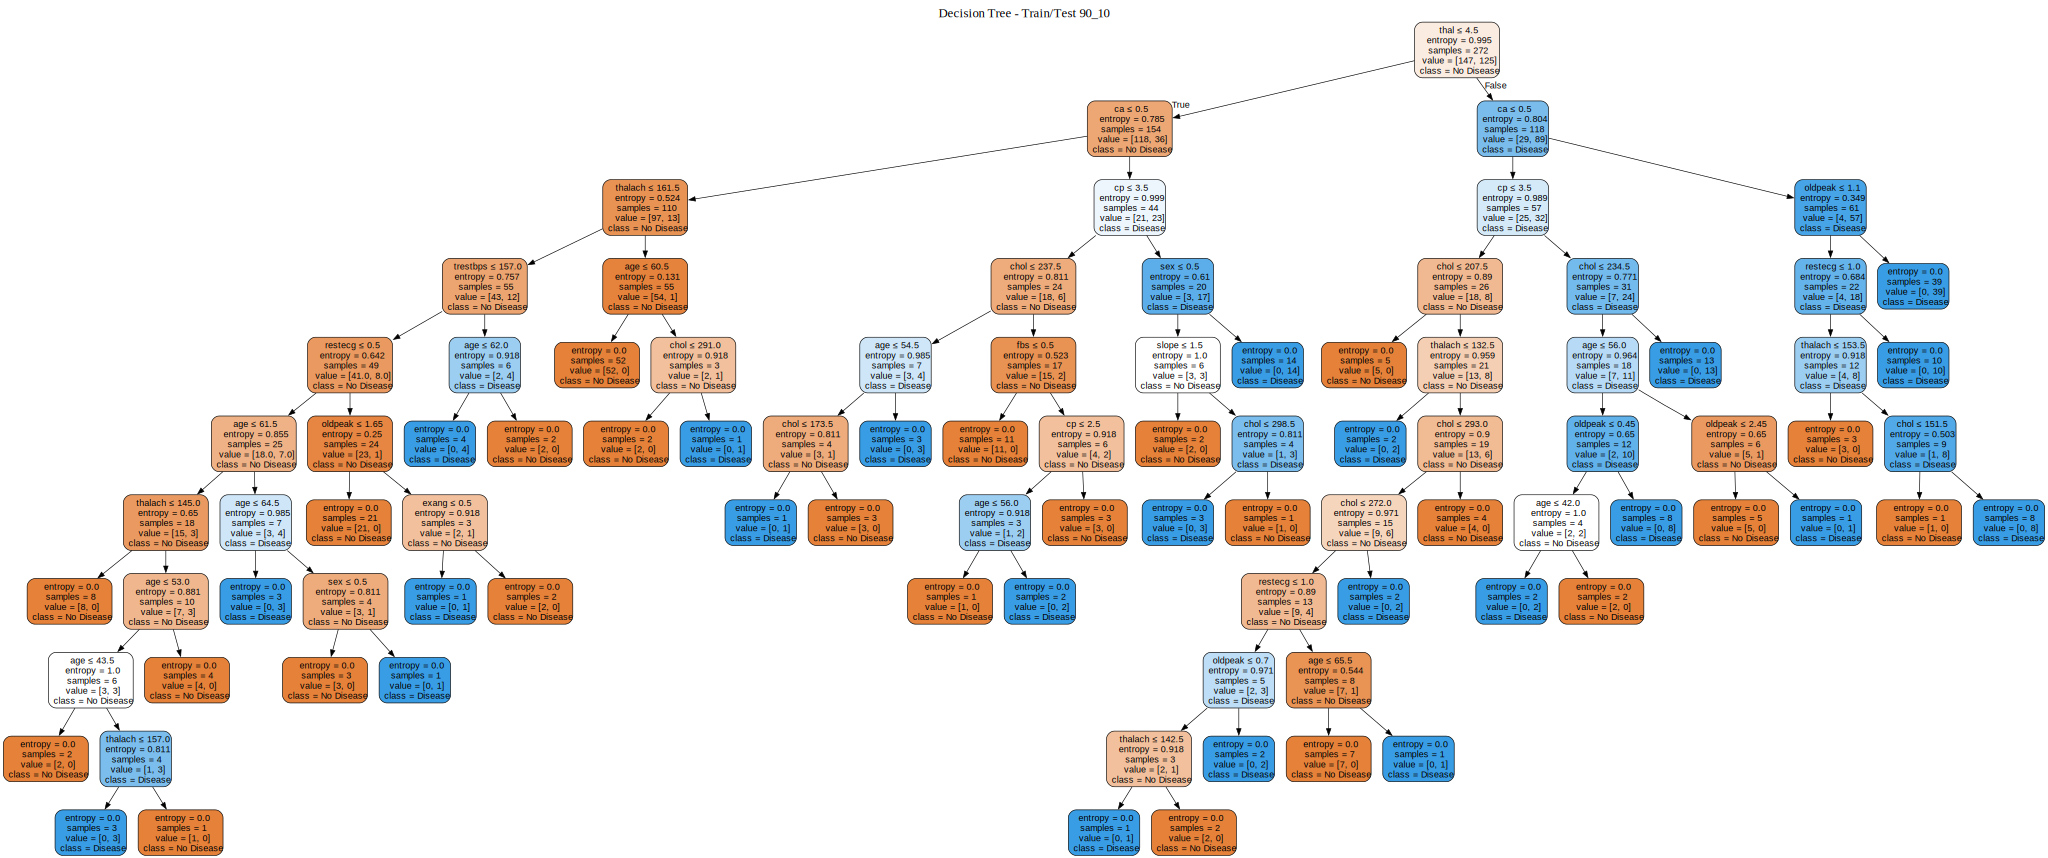

In [11]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

for ratio in split_ratios:
    # Create the key (example: 40_60, 60_40, etc.)
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Get feature_train and label_train
    X_train = datasets[f"feature_train_{key}"]
    clf_train = decision_trees[f"decision_tree_{key}"]
    
    # Export the decision tree to DOT format, adding a name
    dot_data = export_graphviz(
        clf_train,  
        feature_names=X_train.columns, 
        class_names=["No Disease", "Disease"], 
        filled=True, 
        rounded=True,
        special_characters=True,
        out_file=None,
    )
    
    dot_data = dot_data.replace(
        'digraph Tree {',
        f'digraph Tree {{\nlabel="Decision Tree - Train/Test {key}";\nlabelloc=top;\nfontsize=20;'
    )    
    # Render the decision tree using Graphviz
    
    graph = graphviz.Source(dot_data)
    display(graph)


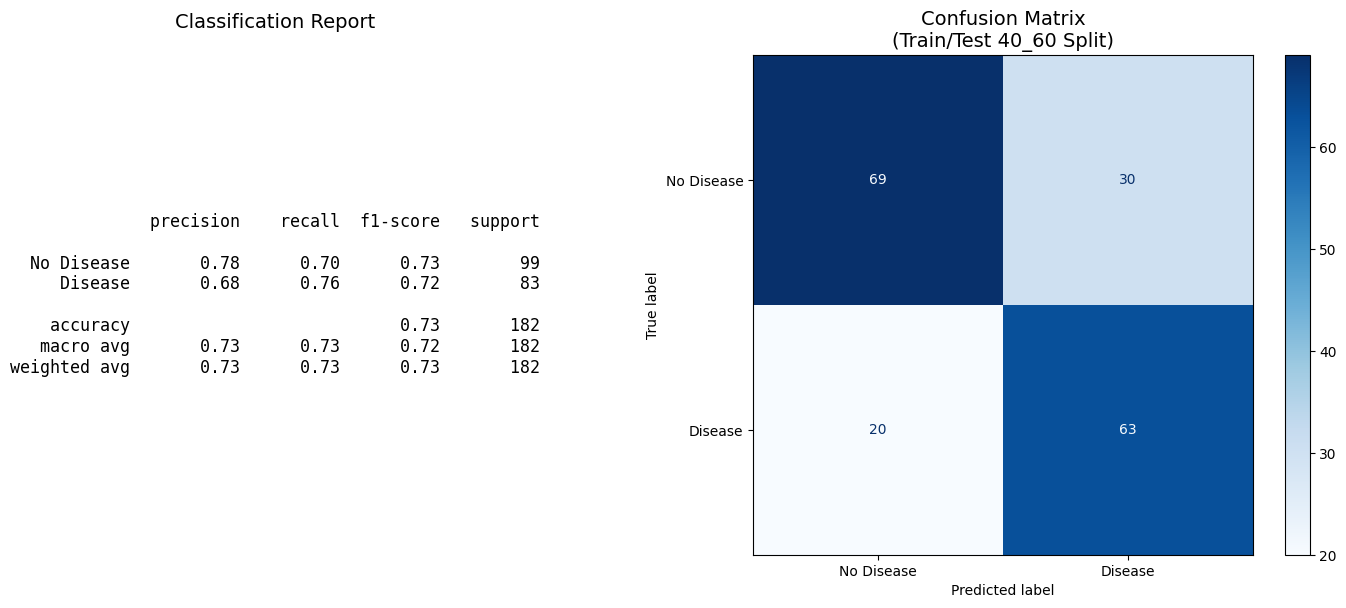

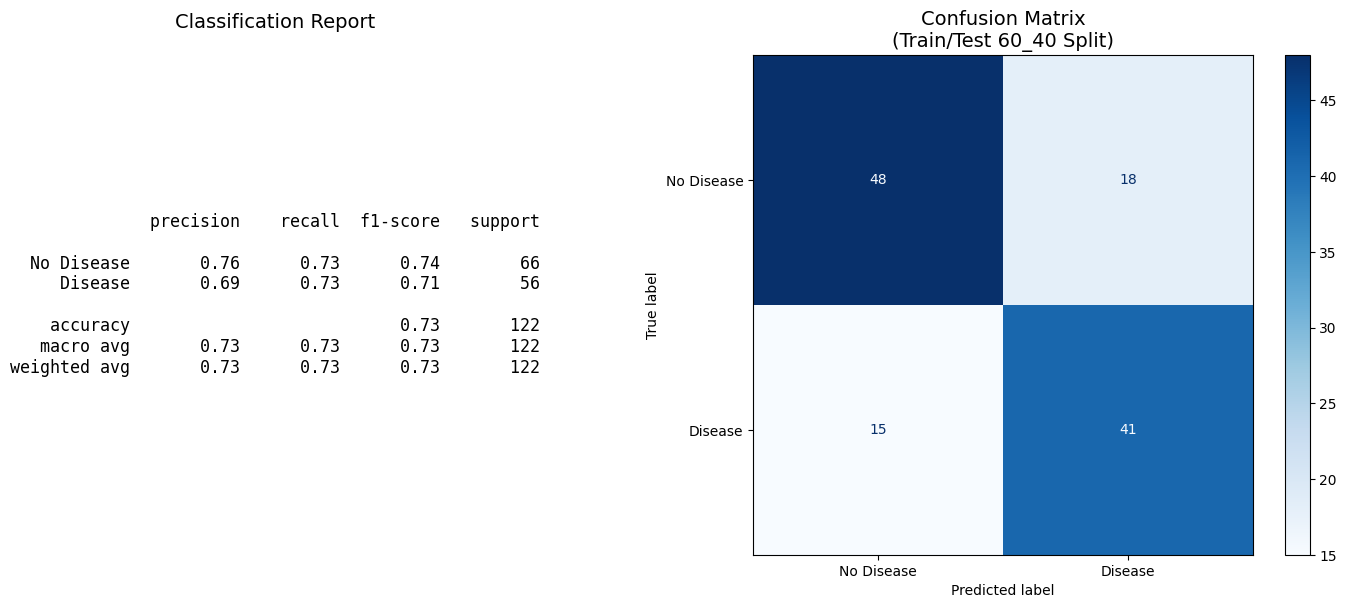

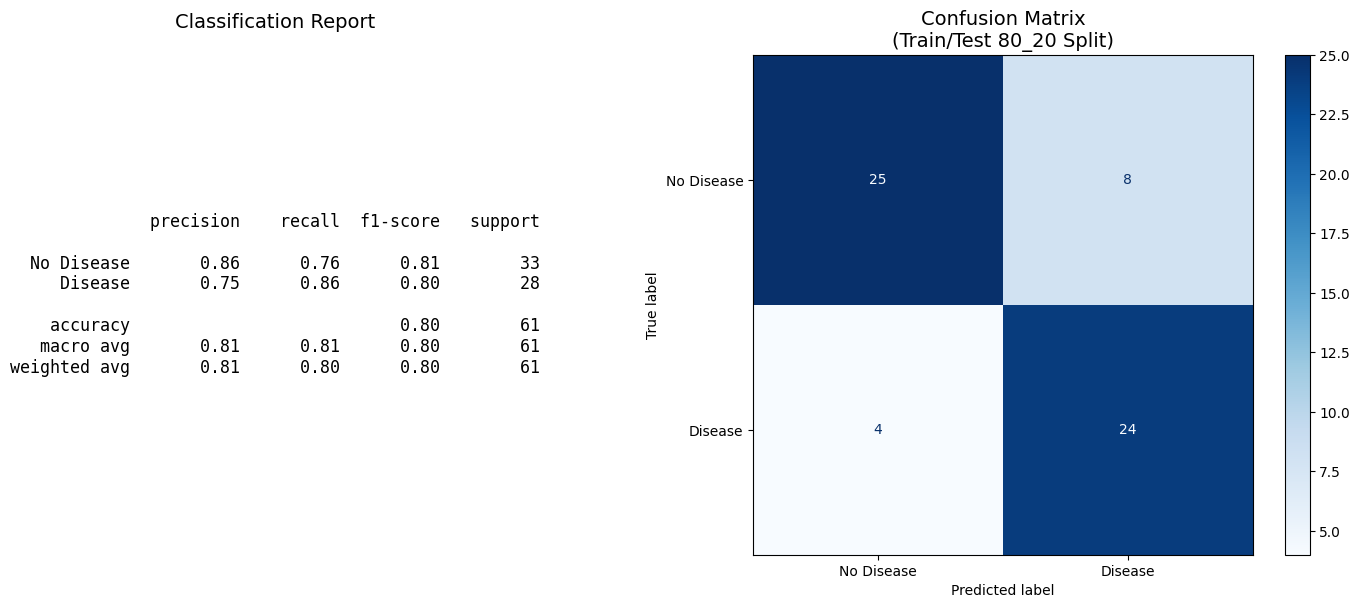

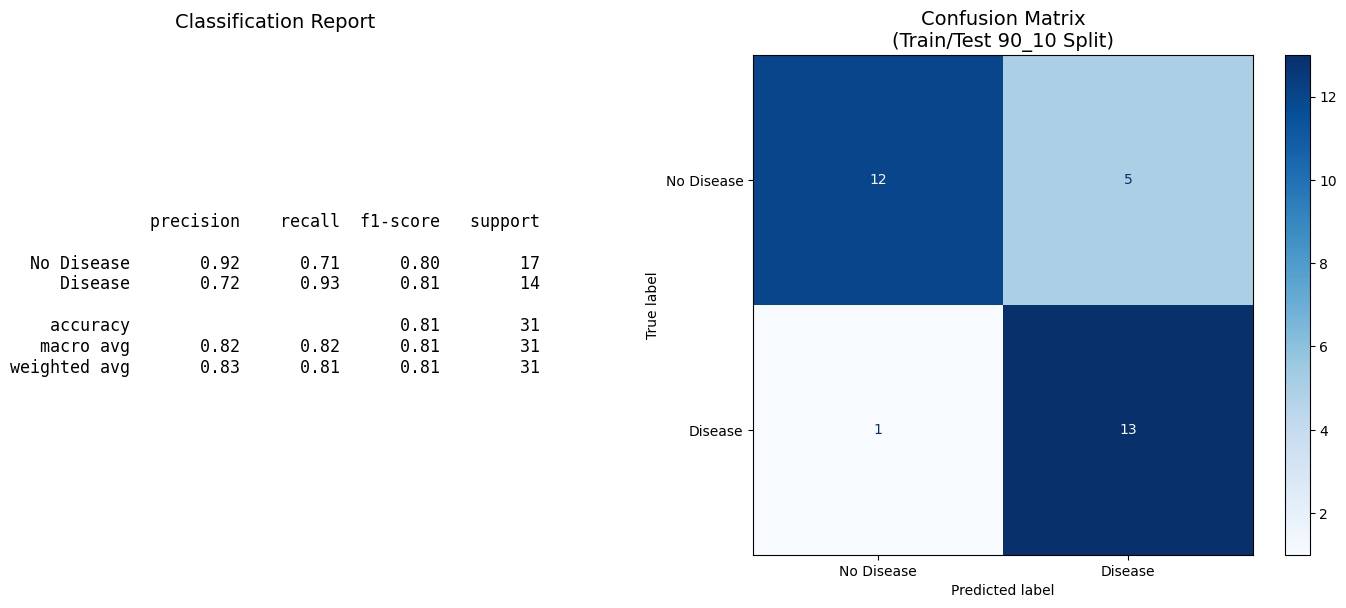

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for ratio in split_ratios:
    # Create key like 80_20
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Load test data
    X_test = datasets[f"feature_test_{key}"]
    y_test = datasets[f"label_test_{key}"]
    
    # Load trained classifier
    clf = decision_trees[f"decision_tree_{key}"]
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Classification report as text
    report_text = classification_report(y_test, y_pred, target_names=["No Disease", "Disease"])
    # print(f"\nClassification Report (Train/Test {key} Split):\n")
    # print(report_text)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot side-by-side: Classification Report (left) and Confusion Matrix (right)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Plot classification report text on the left
    axes[0].axis('off')  # Turn off the axes
    axes[0].text(0, 0.5, report_text, fontsize=12, ha='left', va='center', wrap=True, family='monospace')
    axes[0].set_title("Classification Report", fontsize=14, pad=20)
    
    # Plot confusion matrix on the right
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    disp.plot(cmap='Blues', ax=axes[1], colorbar=True)
    axes[1].set_title(f"Confusion Matrix\n(Train/Test {key} Split)", fontsize=14)
    
    plt.tight_layout()
    plt.show()


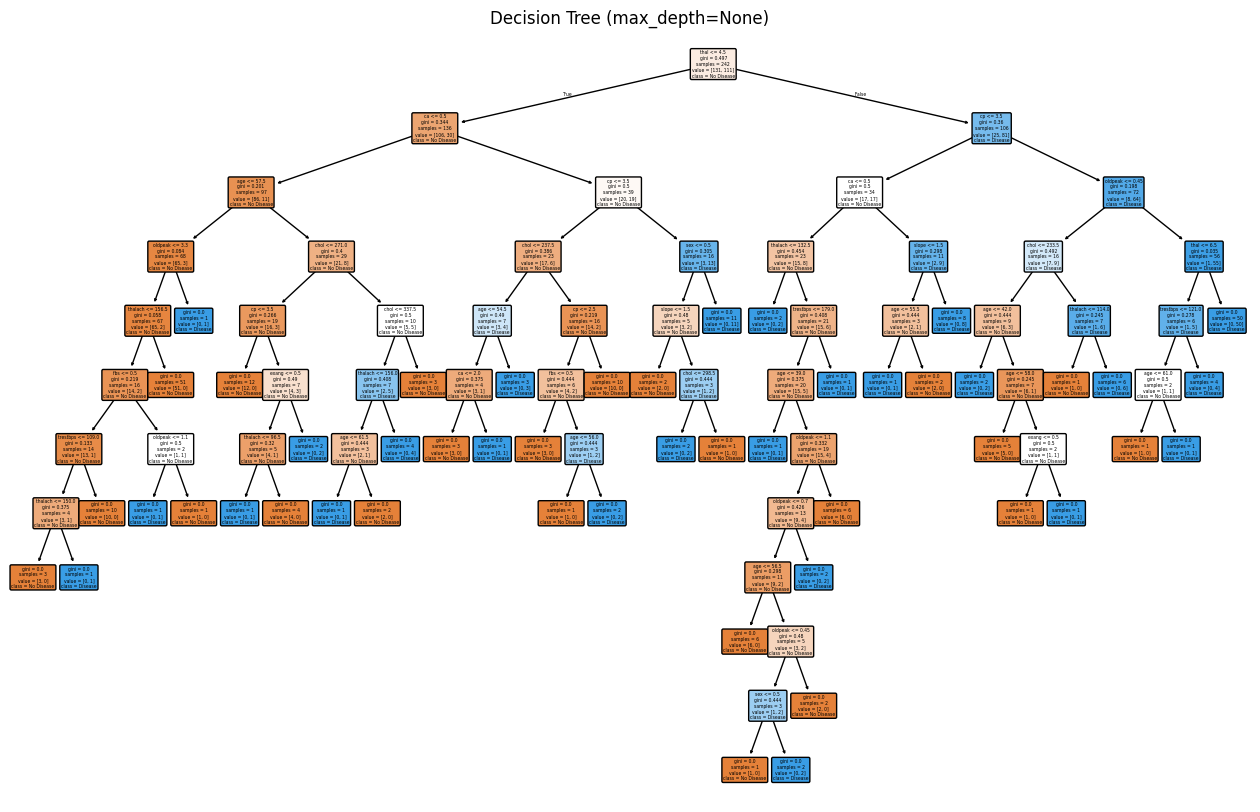

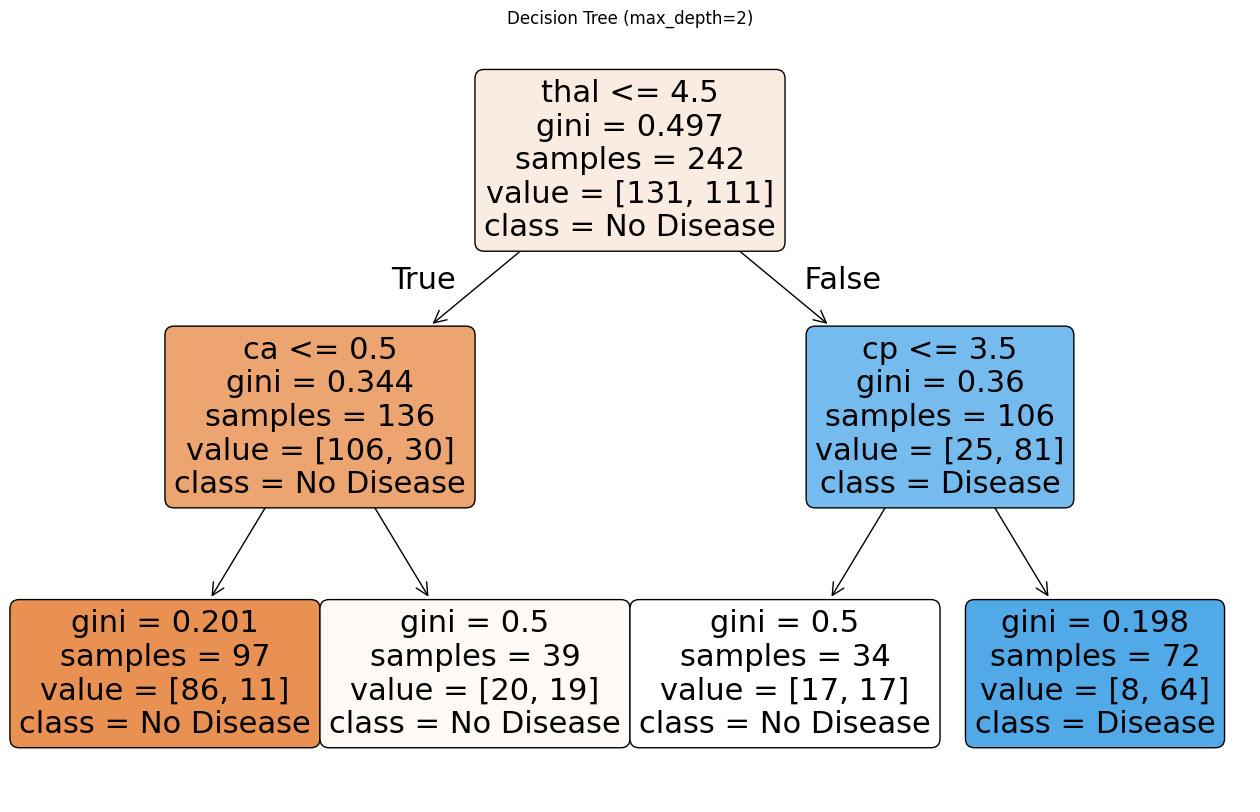

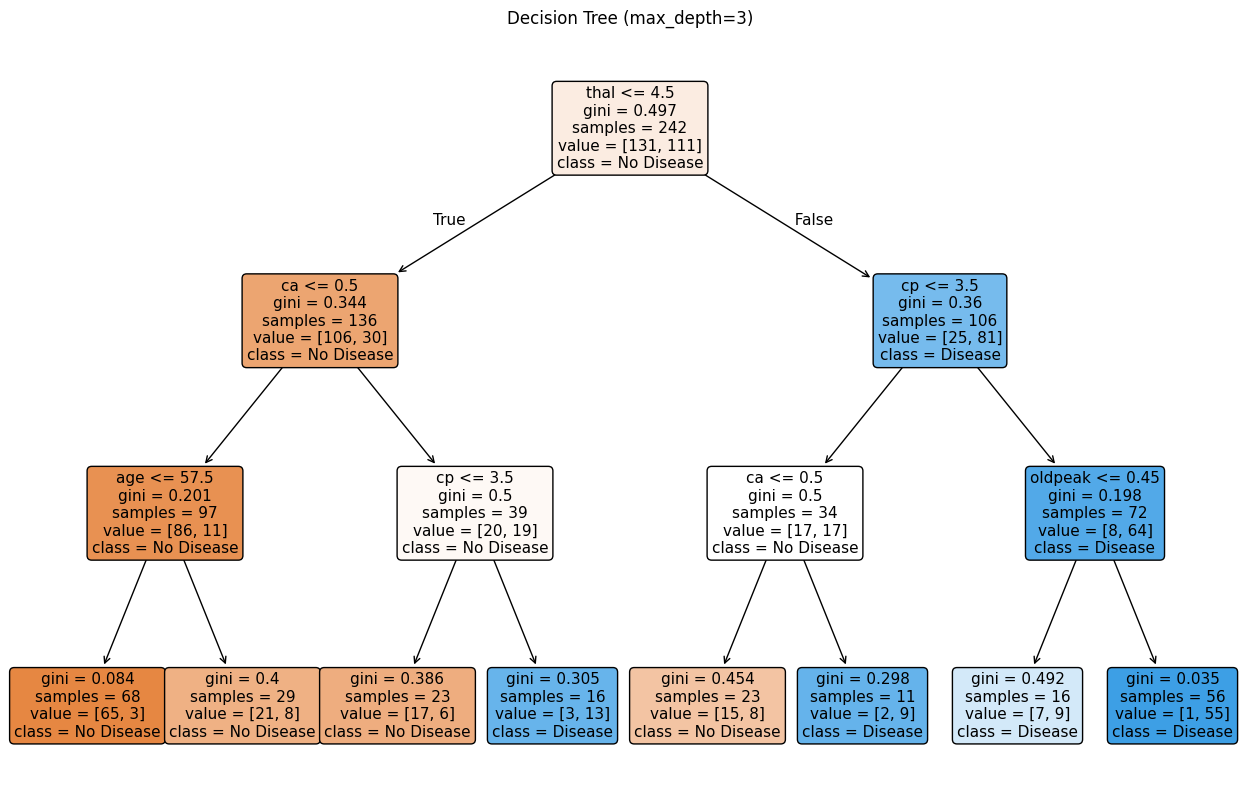

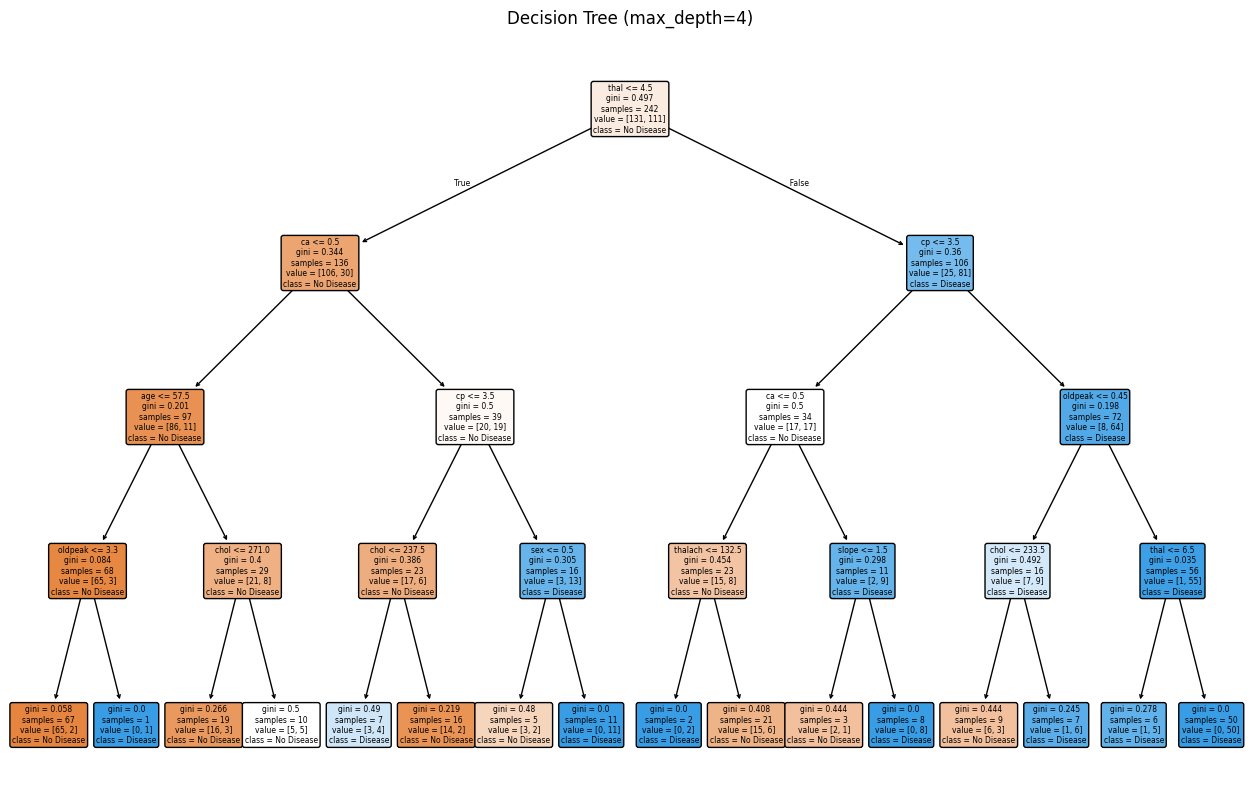

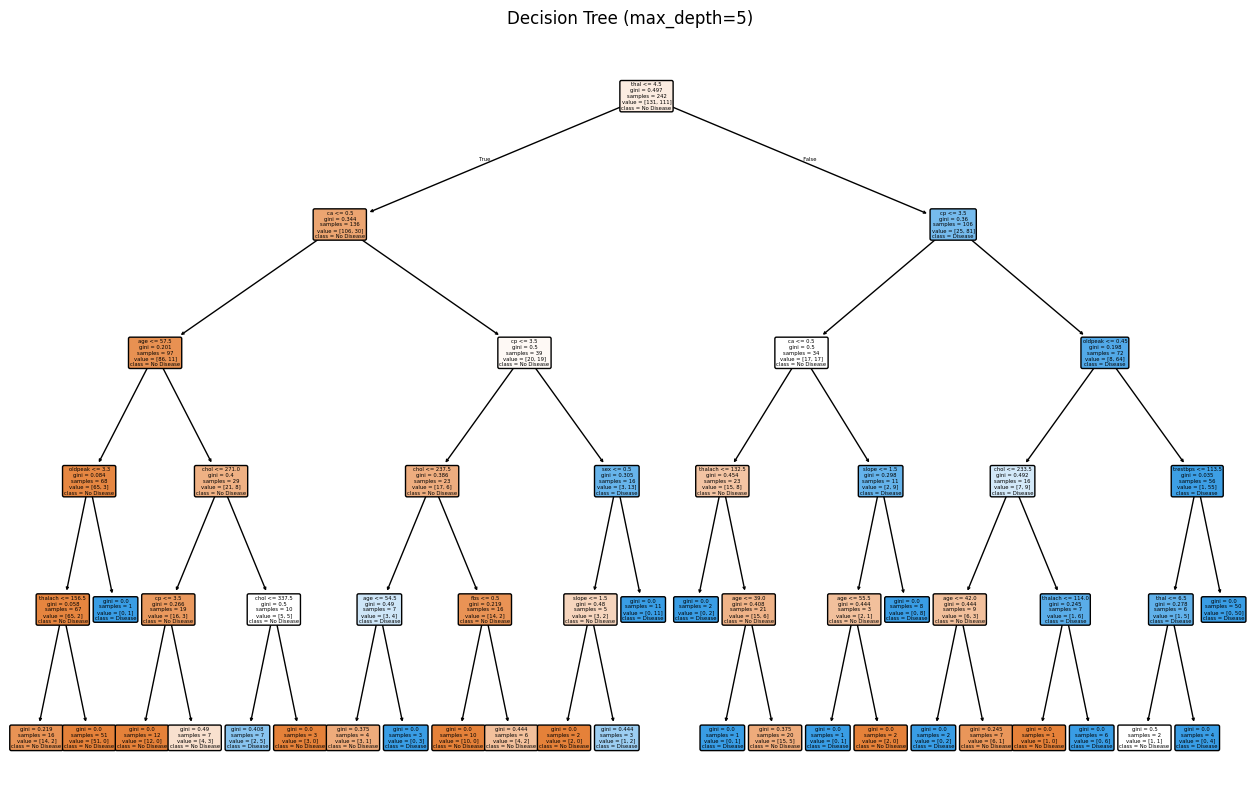

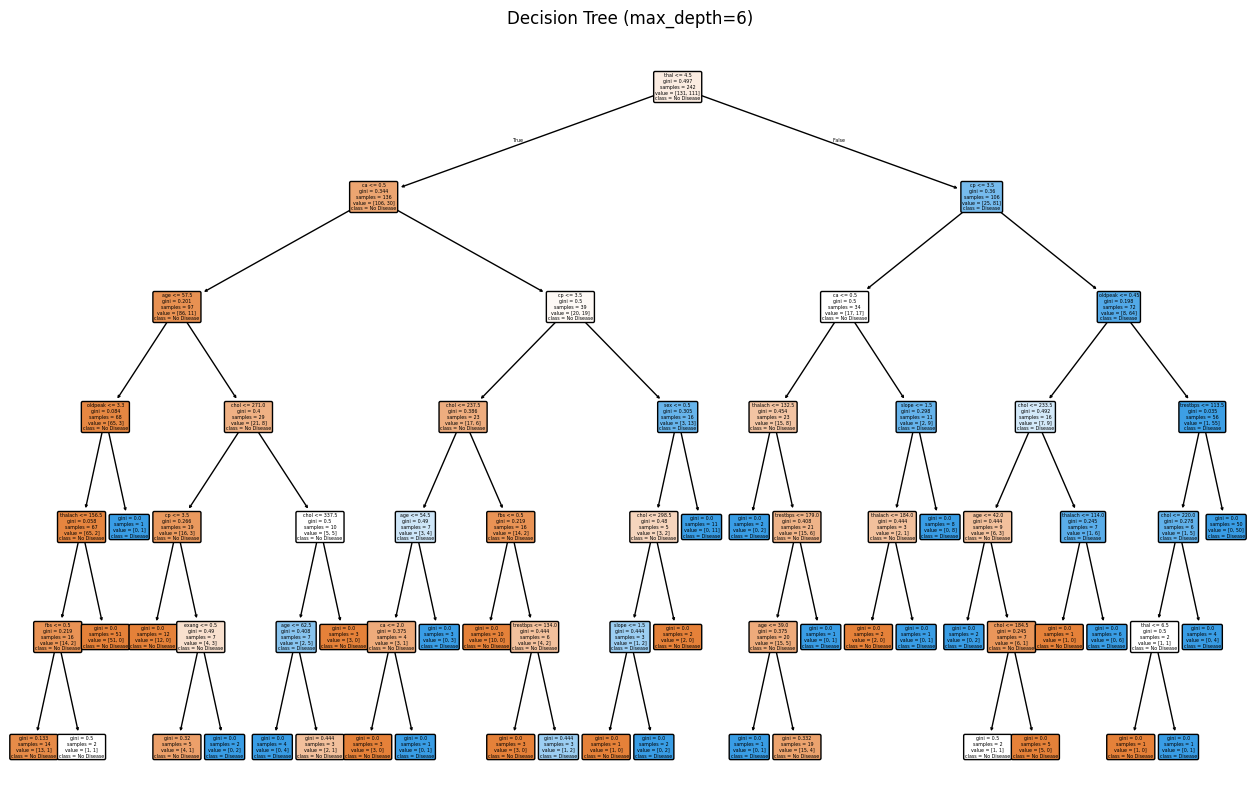

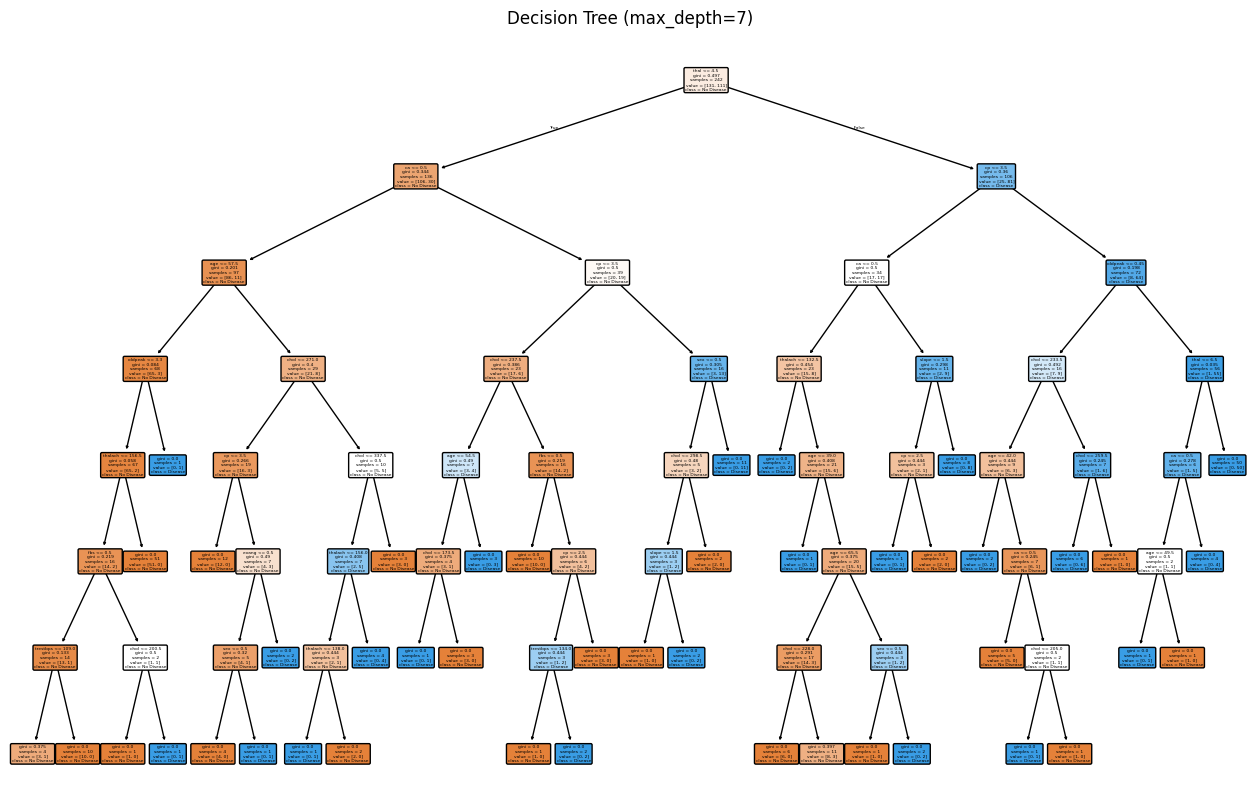


Accuracy Results:
max_depth	Accuracy
None		0.7377
2		0.7705
3		0.8689
4		0.7869
5		0.7869
6		0.8197
7		0.7869


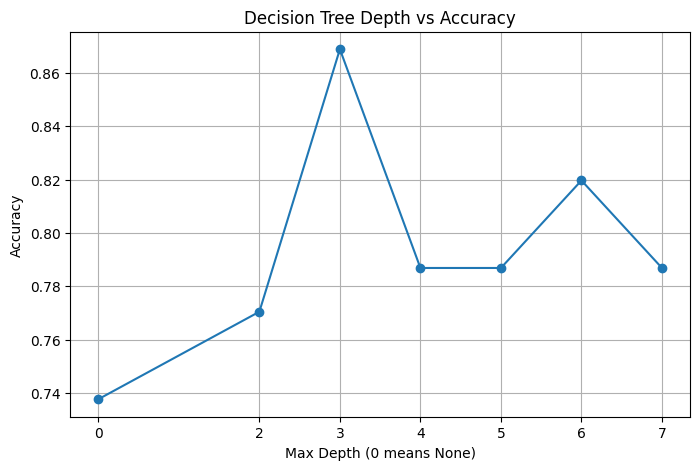

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming your 80/20 dataset is already prepared:
key = "80_20"
X_train = datasets[f"feature_train_{key}"]
y_train = datasets[f"label_train_{key}"]
X_test = datasets[f"feature_test_{key}"]
y_test = datasets[f"label_test_{key}"]

# Depths to try
depths = [None, 2, 3, 4, 5, 6, 7]

# Store results
accuracy_results = {}

for depth in depths:
    # Train decision tree
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    depth_label = "None" if depth is None else str(depth)
    accuracy_results[depth_label] = acc
    
    # Plot tree
    plt.figure(figsize=(16, 10))
    plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["No Disease", "Disease"], rounded=True)
    plt.title(f"Decision Tree (max_depth={depth_label})")
    plt.show()

# Show accuracy table
print("\nAccuracy Results:")
print("max_depth\tAccuracy")
for depth_label, acc in accuracy_results.items():
    print(f"{depth_label}\t\t{acc:.4f}")

# Plot depth vs accuracy
plt.figure(figsize=(8, 5))
depth_labels = list(accuracy_results.keys())
acc_values = list(accuracy_results.values())

# For x-axis, handle 'None' separately
x_labels = [0 if d == "None" else int(d) for d in depth_labels]
plt.plot(x_labels, acc_values, marker='o')
plt.xticks(x_labels)
plt.xlabel('Max Depth (0 means None)')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs Accuracy')
plt.grid(True)
plt.show()
